# Flagging

This guide shows how to use flags in `dysh`.

We should explain the difference between as mask and flags, and everything related to this (e.g. the flag file, the keywords to skip them, etc.)

You can find a copy of this tutorial as a Jupyter notebook [here](https://github.com/GreenBankObservatory/dysh/blob/main/notebooks/examples/flagging.ipynb) or download it by right clicking  <a href="https://raw.githubusercontent.com/GreenBankObservatory/dysh/refs/heads/main/notebooks/examples/flagging.ipynb" download>here</a> and selecting "Save Link As".

## Loading Modules
We start by loading the modules we will use for this example. 

For display purposes, we use the static (non-interactive) matplotlib backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on jupyter lab or notebook.

In [1]:
# Set interactive plots in jupyter.
#%matplotlib ipympl

# We will use matplotlib for plotting.
import matplotlib.pyplot as plt

# These modules are required for working with the data.
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.util.selection import Selection
import numpy as np

# These modules are used for file I/O
from dysh.util.files import dysh_data
from pathlib import Path
import tarfile

## Data Retrieval

This time we download the data from a tar.gz file and then unpack it locally in the current "data" directory.

In [2]:
filename = dysh_data(example="rfi-L/data/AGBT17A_404_01.tar.gz")

In [3]:
# Unpack.
with tarfile.open(filename) as targz:
    targz.extractall('./data/') 
    targz.close() 

## Data Loading

After unpacking the data we load it. Notice how `dysh` tells us that it found a flag file.

In [4]:
sdfits = GBTFITSLoad("./data/AGBT17A_404_01.raw.vegas")

What flags were loaded?

In [5]:
sdfits.flags.show()

 ID TAG OBJECT BANDWID DATE-OBS ... SUBOBSMODE FITSINDEX CHAN UTC # SELECTED
--- --- ------ ------- -------- ... ---------- --------- ---- --- ----------


The above shows that the flag file was empty, so no flags were loaded.

Now, lets look at the summary.

In [6]:
sdfits.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
19,A123606,6600.0,OnOff,1,1.420406,1.420406,1,2,61,1,64.5805,48.3795
20,A123606,6600.0,OnOff,2,1.420406,1.420406,1,2,61,1,64.6012,48.4338


## Data Inspection

There are two scans, a pair of position switched observations. We will calibrate it and see how the data looks like.

We start by looking at the time average of the calibrated data.

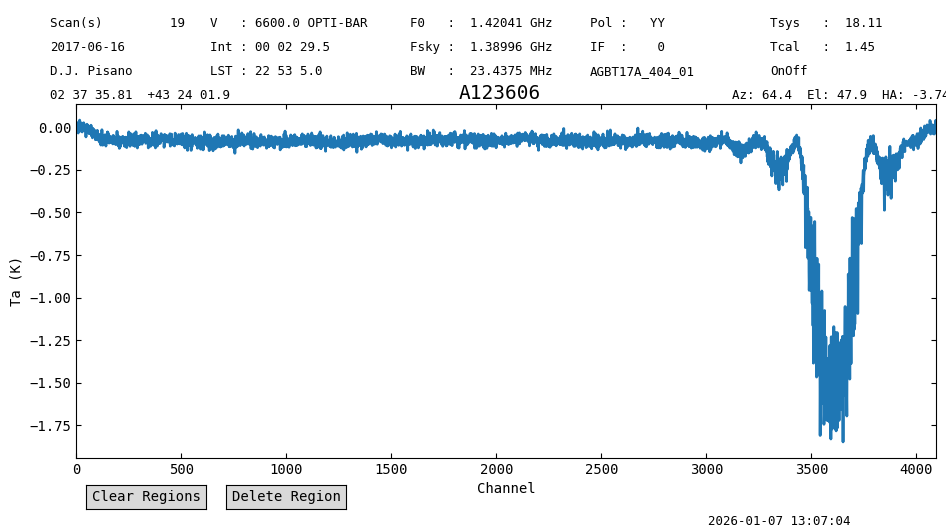

In [7]:
# Calibrate the data.
ps_scanblock = sdfits.getps(scan=19, plnum=0, ifnum=0, fdnum=0)

# Compute the time average.
ps = ps_scanblock.timeaverage()

# Plot.
ps.plot(xaxis_unit="chan")

There is radio frequency interference (RFI) for channels above ~2300. We will plot a waterfall to see if the RFI is confined in time.
This is done using the `plot` method of a `ScanBlock`.

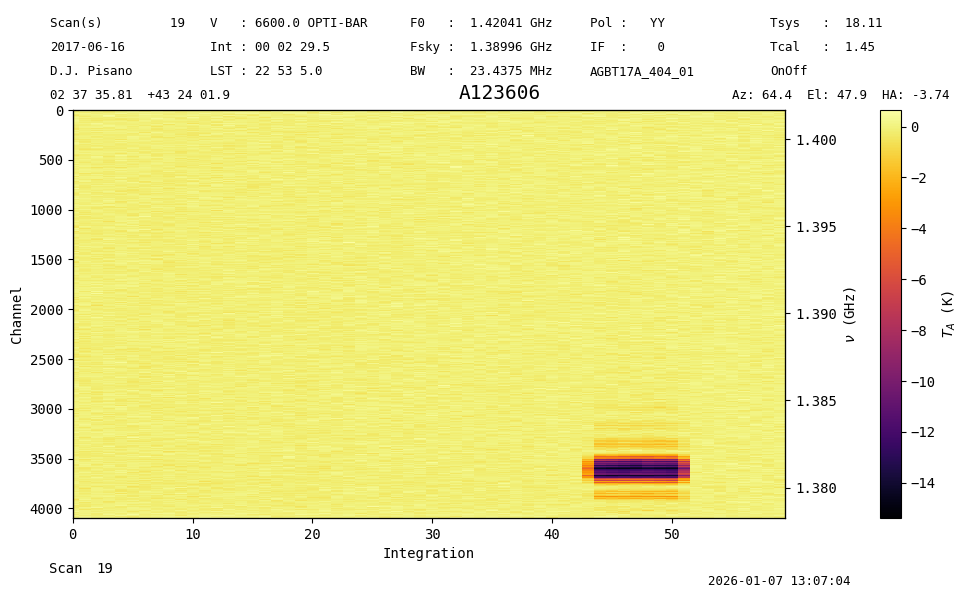

In [8]:
psp = ps_scanblock.plot()

The RFI is confined to integrations 42 to 52, and it affects channels >2300. We will flag this range. Since the RFI shows as negative, it is also likely that this is present in the off scan, `scan=20`. The central frequency of the RFI is 1.381 GHz, which is a notorious GPS signal that shows up intermittendly.

## Data Flagging

We use the `GBTFITSLoad.flag` method to generate flags.

In [9]:
sdfits.flags.clear()
sdfits.flag(scan=20, 
            channel=[[2300,4096]], 
            intnum=[i for i in range(42,53)])
sdfits.flags.show()

 ID    TAG    SCAN             INTNUM                 CHAN     # SELECTED
--- --------- ---- ----------------------------- ------------- ----------
  0 bc3ee34bb   20 [42,43,44,45,...,49,50,51,52] [[2300,4096]]         44


We repeat the calibration after generating the flags.

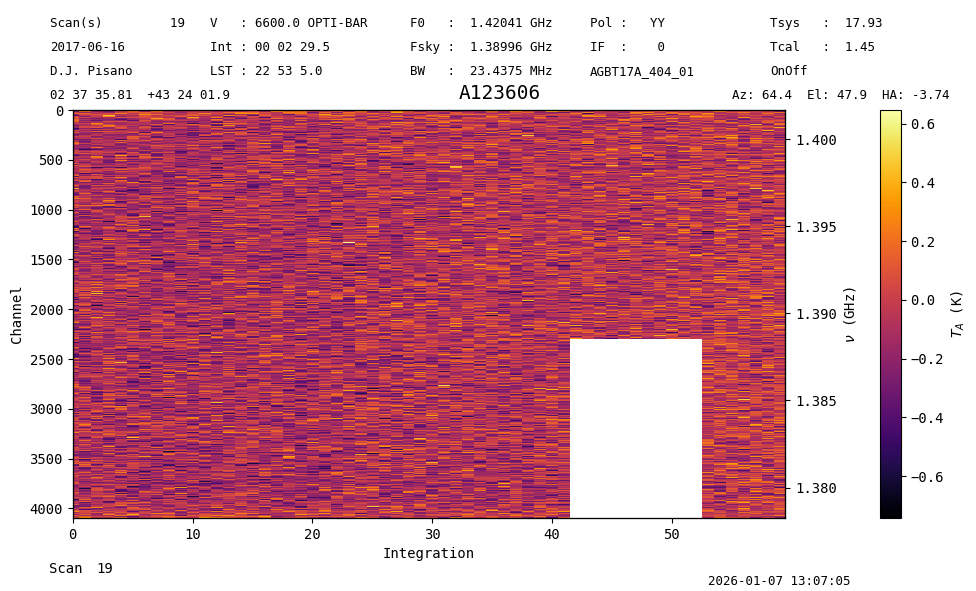

In [10]:
pssb = sdfits.getps(scan=19, plnum=0, fdnum=0, ifnum=0, apply_flags=True)

pssb.plot()

The channels and times affected by RFI have been flagged. We can time average to generate the final spectrum without the RFI.

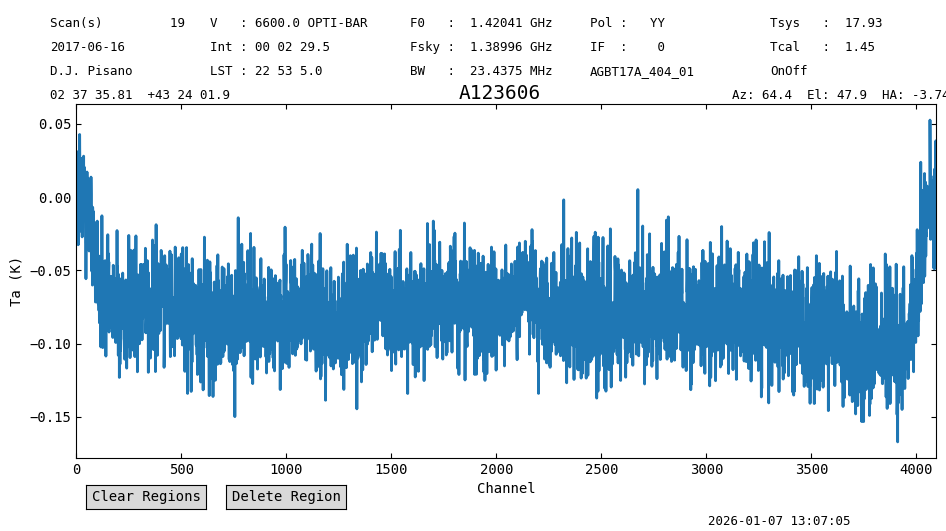

In [11]:
ps = pssb.timeaverage()
ps.plot(xaxis_unit="chan")

## Removing Flags

To remove flags from the `GBTFITSLoad` object use the `clear_flags` method.

In [12]:
sdfits.clear_flags()
sdfits.flags.show()

 ID TAG OBJECT BANDWID DATE-OBS ... SUBOBSMODE FITSINDEX CHAN UTC # SELECTED
--- --- ------ ------- -------- ... ---------- --------- ---- --- ----------


## Statistics-based Flagging

We can assume that any significant increase in the standard deviation of the raw spectra is due to heavy RFI. Below, we will calculate mu + 3*sigma for each of the 8 individual switching states, and flag any integrations breaching that threshold.

The last integration has been blanked by VEGAS, and is not plotted below.

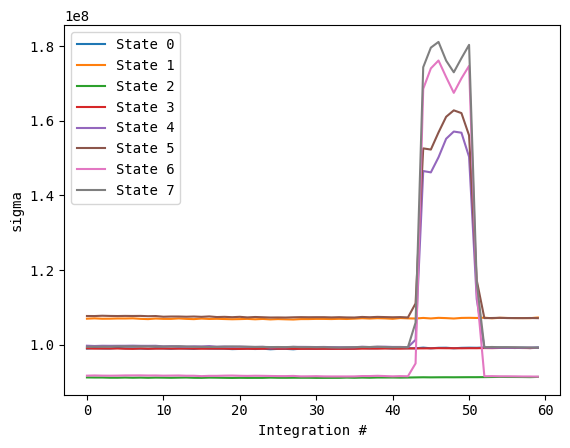

In [13]:
#Get raw spectra and standard deviations
specs = sdfits.rawspectra(0,0)
stdevs = np.std(specs,axis=1)


#Organize into scan and switching state.
#There are 2 scans for the target and reference pointings, 2 calibration diode states, and 2 polarizations.
stdevs = np.reshape(stdevs, (2,-1,4))

nrows = stdevs.shape[1]

#Inspect the data
for scan in range(2):
    for sw_state in range(4):
        plt.plot(stdevs[scan,:-1,sw_state],label=f'State {(4*scan)+sw_state}')
        
plt.xlabel('Integration #')
plt.ylabel('sigma')
plt.legend()

We can see that the 4 states corresponding to the OFF scan have a significant jump corresponding to the GPS L3 RFI. It does not appear to start until the 40th integration, so we will use that as our cutoff to calculate the statistics of the good data, and the thresholds to flag by.

In [14]:
flag_mask = np.zeros(stdevs.shape)
cutoff = 40

mean = np.mean(stdevs[:,:cutoff,:],axis=1)
spread = 3 * np.std(stdevs[:,:cutoff,:],axis=1)

Now we create our flagging mask of zeros and ones, where a one corresponds to a flag to be applied.

In [15]:
flag_mask = np.zeros(stdevs.shape)

mean = np.expand_dims(mean,axis=1)
spread = np.expand_dims(spread,axis=1)

flag_mask[stdevs > mean+spread] = 1
flag_mask = flag_mask.flatten()

flag_rows = np.where(flag_mask==1)[0].tolist()
print(flag_rows)

[176, 178, 185, 186, 187, 190, 191, 194, 195, 198, 199, 201, 202, 203, 206, 207, 208, 209, 210, 211, 214, 215, 216, 217, 218, 219, 222, 223, 226, 227, 230, 231, 234, 235, 236, 237, 238, 239, 240, 242, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 484, 486]


We apply the flags using the "row" keyword, and see that the RFI is removed, along with a drop in the exposure time to 112 seconds instead of the original 150.

112.15101951854204


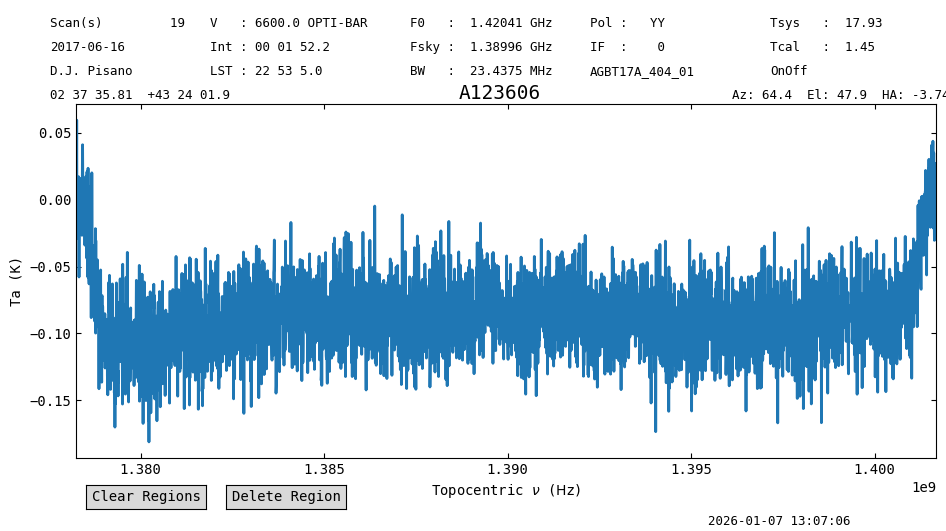

In [16]:
sdfits.flag(row=flag_rows)


ps = sdfits.getps(plnum=0, ifnum=0, fdnum=0).timeaverage()
print(ps.meta['EXPOSURE'])

ps.plot()

## Flags vs. Masks

A few words on flagging vs. masking.   Flagging sets the rule.
`apply_flags()` or calibrating with `apply_flags=True` (the default) sets the data mask.
By default `GBTFITSLoad()` will read flag files and apply them as as a mask.  The keywords `skipflags=` and `flag_vegas=` control which flags are applied.

in any spectrum the `stats()` function
reports the number of "nan", which should be the number of masks that were applied as a result of flagging.

Loaded 2 FITS files


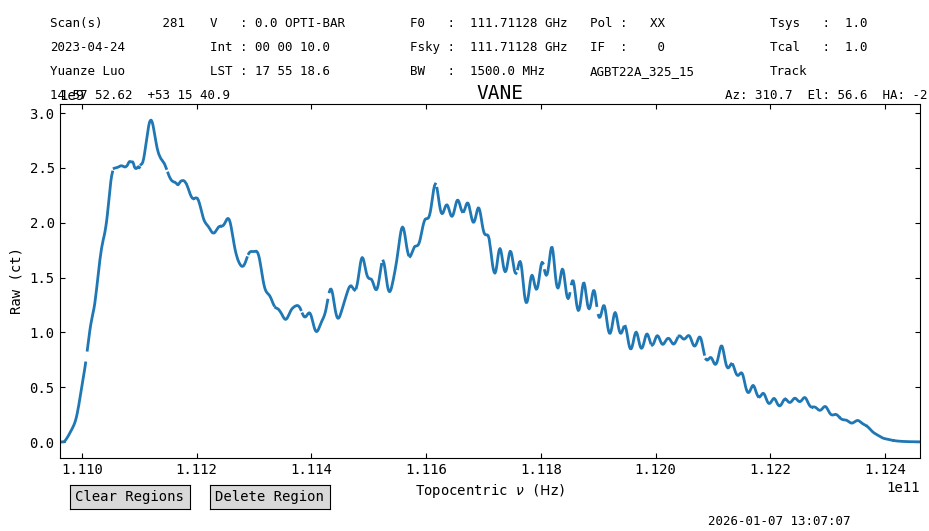

In [17]:
sdf1 = GBTFITSLoad(dysh_data(test="AGBT22A_325_15"))
sp1 = sdf1.gettp(scan=281,ifnum=0,plnum=0,fdnum=8).timeaverage()
sp1.plot()

Looking carefully in this plot, you will see numerous "gaps" in the spectrum, where the so-called VEGAS SPURS were automatically flagged. Using the stats() function
you will see there are 31 in this spectrum of 1024 channels. These are "nan" values in the spectrum, and the `sp1.mask` array has been set appropriately.

In the corresponding `AGBT22A_325_15.raw.vegas.A.flag` file you will see the following:

```
[header]
created = Tue Aug 20 09:38:32 2024
version = 1.0
created_by = sdfits
[flags]
#RECNUM,SCAN,INTNUM,PLNUM,IFNUM,FDNUM,BCHAN,ECHAN,IDSTRING
*|281|*|*|0|8|0,32,64,96,128,160,192,224,256,288,320,352,384,416,448,480,544,576,608,640,672,704,736,768,800,832,864,896,928,960,992|0,32,64,96,128,160,192,224,256,288,320,352,384,416,448,480,544,576,608,640,672,704,736,768,800,832,864,896,928,960,992|VEGAS_SPUR
*|281|*|*|0|10|0,32,64,96,128,160,192,224,256,288,320,352,384,416,448,480,544,576,608,640,672,704,736,768,800,832,864,896,928,960,992|0,32,64,96,128,160,192,224,256,288,320,352,384,416,448,480,544,576,608,640,672,704,736,768,800,832,864,896,928,960,992|VEGAS_SPUR


```



In [18]:
sp1.stats()

{'mean': <Quantity 1.25568126e+09 ct>,
 'median': <Quantity 1.26138573e+09 ct>,
 'rms': <Quantity 7.4497802e+08 ct>,
 'min': <Quantity 849293.34375 ct>,
 'max': <Quantity 2.9360649e+09 ct>,
 'npt': 1024,
 'nan': 31}

Repeating this while ignoring all the flags will show a contiguous spectrum and no masked channels.

Loaded 2 FITS files


{'mean': <Quantity 1.25571771e+09 ct>,
 'median': <Quantity 1.2609328e+09 ct>,
 'rms': <Quantity 7.44805174e+08 ct>,
 'min': <Quantity 849293.34375 ct>,
 'max': <Quantity 2.9360649e+09 ct>,
 'npt': 1024,
 'nan': 0}

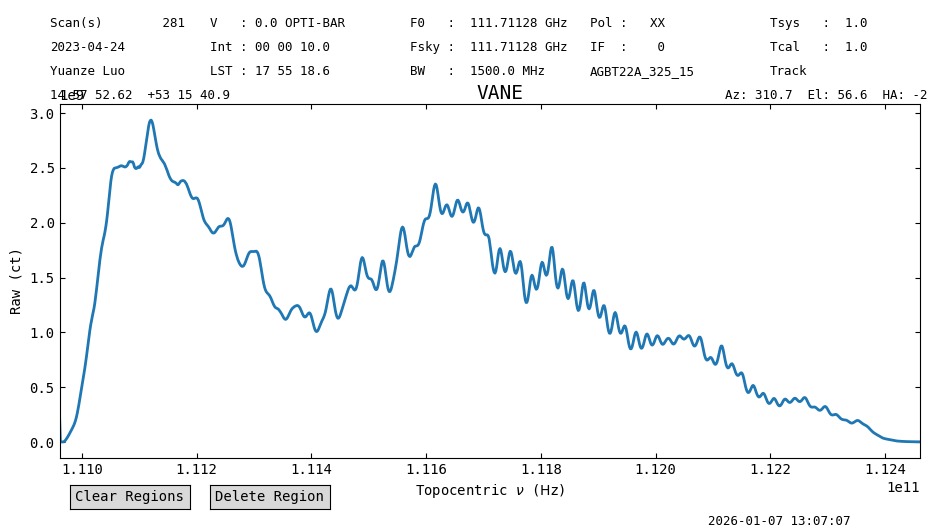

In [19]:
sdf2 = GBTFITSLoad(dysh_data(test="AGBT22A_325_15"), skipflags=True, flag_vegas=False)
sp2 = sdf2.gettp(scan=281,ifnum=0,plnum=0,fdnum=8).timeaverage()
sp2.plot()
sp2.stats()

## Final Stats

Finally, at the end we compute a fairly meaningless statistic over the whole spectrum, merely as a checksum if the notebook produces the same answer as when it was designed.

In [20]:
ps.stats()  # rms: 0.02860246 K

{'mean': <Quantity -0.08575363 K>,
 'median': <Quantity -0.0872892 K>,
 'rms': <Quantity 0.02860246 K>,
 'min': <Quantity -0.18110383 K>,
 'max': <Quantity 0.05951192 K>,
 'npt': 4096,
 'nan': 0}